In [ ]:
!pip install --upgrade tensorflow
!pip install tf-agents[reverb]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 578.0 MB 19 kB/s 
     |████████████████████████████████| 5.9 MB 61.3 MB/s 
     |████████████████████████████████| 1.7 MB 62.1 MB/s 
     |████████████████████████████████| 438 kB 77.8 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Uninstalling gast-0.5.3:
      Successfully uninstalled gast-0.5

# **Imports**

In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import abc
import tensorflow as tf
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt

from tf_agents.environments import py_environment
from tf_agents.environments import tf_environment
from tf_agents.environments import tf_py_environment
from tf_agents.environments import utils
from tf_agents.specs import array_spec
from tf_agents.environments import wrappers
from tf_agents.environments import suite_gym
from tf_agents.trajectories import time_step as ts

from scipy.spatial.distance import cdist
from tf_agents.specs import tensor_spec
from tf_agents.specs import from_spec
from tf_agents.networks import sequential
#from tf_agents.networks import mask_splitter_network
from tf_agents.networks.mask_splitter_network import MaskSplitterNetwork
from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import py_driver
from tf_agents.utils import common
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import replay_buffer
from tf_agents.utils import lazy_loader
from tf_agents.policies import py_tf_eager_policy

import reverb
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils

import tensorflow_probability as tfp

# **VRP parameters**

In [ ]:
#VRP features
N = 20  # number of customers try : 0, 20, 50 and 100
customers = np.array(range(2, N+1)) #list of customers
#customers = list(customers)
M = 4 # number of vehicles
max_capacity = 25 # Vehicles capacity coreesponding to number of customers 20, 30, 40 and 50
ENV_SIZE = N
Loads = np.zeros(shape=N)
Distance = np.zeros(shape=(N,N)) # distance matrix
coords = np.random.rand(N,2)*ENV_SIZE #or randomly generated in the unit square [0,1] * [0,1]

# **DQN parameters**

In [ ]:
fc_layer_params = (100,)

#num_iterations = 10000 # @param {type:"integer"}

initial_collect_steps = N+M+1  # @param {type:"integer"}
collect_steps_per_iteration = N+M+1 # N+M+1 # @param {type:"integer"}
replay_buffer_max_length = 100#100000  # @param {type:"integer"}

batch_size = 30  # @param {type:"integer"}
learning_rate = 1e-2  # @param {type:"number"}
log_interval = N+M+1 #200  # @param {type:"integer"}

num_eval_episodes = 10  # @param {type:"integer"}
eval_interval = 100  # @param {type:"integer"}
epsilon_greedyp = 0.6

num_iterations = batch_size * eval_interval

# number of examples = n_epochs * n_inputs

# **Environment**

In [ ]:
class VRPenvironement2(py_environment.PyEnvironment):

  def __init__(self,N,M,customers,coords, Loads,max_capacity):

        # Store default parameters
        self.N = N
        self.customers = customers
        self.M = M
        self.coords = coords
        self.Loads = Loads
        self.max_capacity = max_capacity

        self.Loads = np.random.randint(1,high=9, size=self.N) # chosen uniformly at random
        print("ld ",self.Loads)
        self.Loads[0]=0
        print("ld ",self.Loads)
        self.Distance = cdist(self.coords, self.coords)
        print(self.Distance)

        self.Depot = 1
        self.Loaded_weight = 0
        self.Tot_Cost = 0

        self.lg = 0
        self.nv = 1

        # Configuration for RL agent
        self._observation_spec = {
                                'observations': array_spec.ArraySpec(shape=(self.N + self.M + 1,), dtype=np.int32, name='observations'),
                                'valid_actions': array_spec.ArraySpec(shape=(self.N - 1,), dtype=bool, name='valid_actions')
                                }
        self._reward = array_spec.ArraySpec(shape=(), dtype=np.float32, name='reward')
        self._action_spec = array_spec.BoundedArraySpec(
        shape=(), dtype=np.int32, minimum=0, maximum=self.N - 2, name='action')
        self._step_type = array_spec.ArraySpec(shape=(), dtype=np.int32, name='step_type')

        self._state = np.array([], dtype=np.int32)
        self._state = np.zeros(self.N + self.M + 1)
        self._masks = np.full((self.N - 1,), True, dtype=bool)


        self.ls = 0
        self.addedC = 0
        self.X = np.zeros((self.N,self.N))
        self.reset()
        print("after 1st reset")

  def action_spec(self):
    return self._action_spec

  def observation_spec(self):
    return self._observation_spec

  def observation_spec1(self):
    return self._observation_spec['observations']

  def __is_cust_in(self, index):
    for item in self._state:
        if item == index:
          return 1
    return 0

  def __all_road_occupied(self):
    sc = 0
    for i in range(0,N):
      for item in self._state:
        if item == i:
          sc = sc + 1
    return (sc == N)

  def __compute_total_Cost(self):

        self.X[int(self._state[self.ls-1]-1),0] = 1
        Tcost = -1 * np.sum(self.Distance @ self.X)
        self.X[int(self._state[self.ls-1]-1),0] = 0
        return Tcost

  def __compute_reward(self):
        self.Tot_Cost = -1 * self.__compute_total_Cost()

        return self.Tot_Cost

  #def __observation_action_splitter(self):
	#  return self._observation_spec['observations'], self._observation_spec['valid_actions']

  def __obs(self, obs, mask):
    return {'observations': obs, 'valid_actions': mask}

  def __observation_and_action_constraint_splitter(self):
     #self._mask = np.full((self.N - 2,), False, dtype=bool)
     for elem in self._state:
          if elem != 1 and elem != 0:
               self._masks[int(elem) - 2] = False #valid action

     return tf.convert_to_tensor(self._state, dtype=np.int32), tf.convert_to_tensor(self._masks, dtype=bool)

  #def _splitter_fn(self):
  #  self.observation_spec['observations'], self._observation_spec['valid_actions'] = self.__observation_and_action_constraint_splitter()
  #  return self.observation_spec['observations'], self.observation_spec['valid_actions']

  def _reset(self):
    print("reset")
    self.lg = 0
    self._reward = 0
    self.Loaded_weight = 0
    self._discount = 1.0
    self.ls = 0
    self.addedC = 1
    self.Tot_Cost = 0

    state = np.array([], dtype=np.int32)
    state = np.zeros(self.N + self.M + 1)

    self._state = state
    self._masks = np.full((self.N - 1,), True, dtype=bool)
    #obs['observation'] = get_the_env_observations(…)
    #obs['valid_actions'] = get_valid_actions_masks(…) # True for valid and False for invalid actions
    print(self._state)
    self._episode_ended = False

    #return ts.restart([self.__obs(np.array(self._state, dtype=np.int32), self._masks)])
    return ts.restart(self.__obs(np.array(self._state, dtype=np.int32), self._masks))
    #return ts.restart([self.__obs(self._state, self._masks)])

  def _step(self, action):
    print("step: ", action+2)
    #masks = get_valid_actions_masks(…)
    if not self._masks[action]:
      print("Error: Invalid action is taken")
    #  #sys.exit(-1)
    else:
      self._masks[action] = False

    if self.addedC == self.N:
      return ts.termination(self.__obs(np.array(self._state, dtype=np.int32), self._masks), self._reward)
    print("action: ", action+2)
    self.lg = self.lg + 1
    if(self.lg > 3*N):
      #return ts.termination([self.__obs(np.array(self._state, dtype=np.int32), self._masks)], self._reward)
      return ts.termination(self.__obs(np.array(self._state, dtype=np.int32), self._masks), self._reward)

    if self.ls == 0:

        self._state[self.ls] = 1
        self.ls = self.ls + 1
        self.addedC = 1
        self.Loaded_weight = 0
        #ts.transition([self.__obs(np.array(self._state, dtype=np.int32), self._masks)], self._reward)
        ts.transition(self.__obs(np.array(self._state, dtype=np.int32), self._masks), self._reward)

    if self.__is_cust_in(action+2) == 0:
        print("max_capacity ",self.max_capacity)

        print("Loaded_weight ", self.Loaded_weight)
        if((self.Loaded_weight + self.Loads[action+1])  < self.max_capacity):
            print("1Loaded_weight+ ", (self.Loaded_weight + self.Loads[action+1]))

            self.X[int(self._state[self.ls-1]-1),int(action+1)] = 1
            self._state[self.ls] = int(action+1 + 1)
            self.ls = self.ls + 1
            self.addedC = self.addedC + 1
            self.Loaded_weight = self.Loaded_weight + self.Loads[action+1]

        else:
            print("add an other car")
            #increment number of vehicles
            self.nv = self.nv + 1

            #if(self._state[len(self._state)-1] != 1):
            if(self._state[self.ls-1] != 1):
              self._state[self.ls] = 1
              self.ls = self.ls + 1
              self.X[int(self._state[self.ls-1]-1),0] = 1
              self.Loaded_weight = 0
            # Action of adding customer c at the end
            if((self.Loaded_weight + self.Loads[action+1])  < self.max_capacity):
              print("Loaded_weight+ ", (self.Loaded_weight + self.Loads[action+1]))
              # Action of adding customer c at the end
              self.X[int(self._state[self.ls-1]-1),action+1] = 1
              self._state[self.ls] = int(action+1+1)
              self.ls = self.ls + 1
              self.addedC = self.addedC + 1
              self.Loaded_weight = self.Loaded_weight + self.Loads[action+1]


        if self.addedC == self.N:
          self._state[self.ls] = 1
          self.ls = self.ls + 1
          self.X[int(self._state[self.ls-1]-1),0] = 1
        #Computing and returning the reward
        if(self.ls >= 2):
          self.Tot_Cost = self.Tot_Cost + (ENV_SIZE - self.Distance[int(self._state[int(self.ls-2)]-1),int(self._state[int(self.ls-1)]-1)] * self.X[int(self._state[int(self.ls-2)]-1),int(self._state[int(self.ls-1)]-1)])
        else:
          self.Tot_Cost = 0

        #self._reward = self._reward + (1000 - self.Tot_Cost)
        self._reward = self._reward + self.Tot_Cost
        print("gr: ",self._reward)
        s_next = action
        self._episode_ended = (self.addedC == self.N)
        print("ending episode1", self._episode_ended)

        if self._episode_ended:
          #return ts.termination([self.__obs(np.array(self._state, dtype=np.int32), self._masks)], self._reward)
          return ts.termination(self.__obs(np.array(self._state, dtype=np.int32), self._masks), self._reward)
        else:
          #return ts.transition([self.__obs(np.array(self._state, dtype=np.int32), self._masks)], self._reward)
          return ts.transition(self.__obs(np.array(self._state, dtype=np.int32), self._masks), self._reward)

    else:

        #self._reward = -1 * (self._reward + 2 * ENV_SIZE) #-math.inf
        self._reward = self._reward - 2 * ENV_SIZE
        print("br: ",self._reward)
        #return ts.transition([self.__obs(np.array(self._state, dtype=np.int32), self._masks)], self._reward)
        return ts.transition(self.__obs(np.array(self._state, dtype=np.int32), self._masks), self._reward)

        self._episode_ended = (self.addedC == self.N)
        print("ending episode2", self._episode_ended)


In [ ]:
#def splitter_fn(observation_and_mask):
#    return observation_and_mask['observations'], observation_and_mask['valid_actions']

In [ ]:
def observation_and_action_constraint_splitter(observation):
     print("observation ", observation)
     print("state ", observation['observations'])

     #state = (observation[0][0])
     #mask = np.full((N - 2,), False, dtype=bool)
     #for elem in state:
     #     if elem != 1 and elem != 0:
     #          mask[int(elem) - 2] = False #valid action

     #return observation['observations'], tf.convert_to_tensor(mask, dtype=bool)

def splitter_fn(observation_and_mask):
    #observation_and_mask['observations'], observation_and_mask['valid_actions'] = observation_and_action_constraint_splitter(observation_and_mask)
    #print(env.observation_spec['observations'])
    #print(env.observation_spec['valid_actions'])
    return observation_and_mask['observations'], observation_and_mask['valid_actions']

In [ ]:
env = VRPenvironement2(N,M,customers,coords,Loads,max_capacity)
tf_env = tf_py_environment.TFPyEnvironment(env)

train_py_env = VRPenvironement2(N,M,customers,coords,Loads,max_capacity)
eval_py_env = VRPenvironement2(N,M,customers,coords,Loads,max_capacity)

train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)


#env.reset()
#env.step(2)

#print(splitter_fn(env._observation_spec))

ld  [5 4 4 8 4 8 3 3 5 2 2 1 4 3 4 8 6 6 2 6]
ld  [0 4 4 8 4 8 3 3 5 2 2 1 4 3 4 8 6 6 2 6]
[[ 0.          3.95198098  6.01052114 12.31455169  7.30384382 11.1883957
  15.36308519 13.91485782 16.59536929  2.76940835 14.01206717  8.33708092
  16.59867848 14.27413627 11.04137357  6.62991984 14.33070509 14.8669568
   8.88269831  5.93568556]
 [ 3.95198098  0.          5.86654744 14.83201044  3.36218314  7.35889893
  13.54012009 11.82303699 16.20482995  2.03323992 13.77558707  4.59614396
  16.47124698 13.01868887 13.60851248  5.86544785 15.4020818  11.77159113
  10.91724302  2.68631492]
 [ 6.01052114  5.86654744  0.         10.05775251  7.31312299  9.39084217
   9.59623065  8.39404245 10.69708633  6.94087633  8.15474887  6.9216408
  10.8161436   8.3006773   8.99732144  1.01600215  9.57902657 10.53976965
   5.96881341  8.4594488 ]
 [12.31455169 14.83201044 10.05775251  0.         17.17292312 19.40959616
  15.49187863 15.46418223 11.8163843  14.81219171 10.06118069 16.97286589
  10.99741633 13

In [ ]:
print(env.observation_spec1())
print(from_spec(env.observation_spec1()))

ArraySpec(shape=(14,), dtype=dtype('int32'), name='observations')
TensorSpec(shape=(14,), dtype=tf.int32, name='observations')


# **Agent**

In [ ]:
action_tensor_spec = tensor_spec.from_spec(env.action_spec())
print(action_tensor_spec)
num_actions = action_tensor_spec.maximum - action_tensor_spec.minimum + 1
print(num_actions)

# Define a helper function to create Dense layers configured with the right
# activation and kernel initializer.
def dense_layer(num_units):
  return tf.keras.layers.Dense(
      num_units,
      activation=tf.keras.activations.relu,
      kernel_initializer=tf.keras.initializers.VarianceScaling(
          scale=3.0, mode='fan_in', distribution='truncated_normal'))

# QNetwork consists of a sequence of Dense layers followed by a dense layer
# with `num_actions` units to generate one q_value per available action as
# its output.
#input_layer = tf.keras.layers.Dense(100, name="input",input_shape=(14,))
dense_layers = [dense_layer(num_units) for num_units in fc_layer_params]
q_values_layer = tf.keras.layers.Dense(
    #observation_spec['observations'],
    num_actions,
    activation=None,
    kernel_initializer=tf.keras.initializers.RandomUniform(
        minval=-0.06, maxval=0.06),
    bias_initializer=tf.keras.initializers.Constant(-0.2))#,train_env.observation_spec()['observations'], train_env.action_spec(), name= 'q_net'
q_net = sequential.Sequential(dense_layers + [q_values_layer], train_env.observation_spec()['observations'])#, from_spec(env.observation_spec1())

#qq_net = MaskSplitterNetwork(splitter_fn, q_net, train_env.observation_spec(), passthrough_mask=True)


BoundedTensorSpec(shape=(), dtype=tf.int32, name='action', minimum=array(0, dtype=int32), maximum=array(18, dtype=int32))
19


In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

#train_step_counter = tf.Variable(0)
train_step_counter = tf.compat.v2.Variable(0)
#train_step_counter = tf.Variable(0, dtype=tf.int64)

agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    epsilon_greedy = epsilon_greedyp,
    #gamma = 0.2,
    ##observation_and_action_constraint_splitter = train_env.observation_and_action_constraint_splitter(),
    observation_and_action_constraint_splitter = splitter_fn,
    td_errors_loss_fn=common.element_wise_squared_loss, #common.element_wise_huber_loss,
    train_step_counter=train_step_counter)

agent.initialize()

# **Policies**

In [ ]:
eval_policy = agent.policy #used for evaluation and deployment.
collect_policy = agent.collect_policy #used for data collection.

In [ ]:
#randomly select an action for each time_step
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

In [ ]:
env1 = VRPenvironement2(N,M,customers,coords,Loads,max_capacity)
tf_env1 = tf_py_environment.TFPyEnvironment(env)
time_step = tf_env1.reset()
print("q: ", q_net(time_step.observation['observations']))
print("random")
c = random_policy.action(time_step)
time_step = tf_env1.step(c)
print("q: ", q_net(time_step.observation['observations']))
print("policy")
c = eval_policy.action(time_step)
time_step = tf_env1.step(c)
print(time_step)
print("q: ", q_net(time_step.observation['observations']))
print("random")
c = random_policy.action(time_step)
time_step = tf_env1.step(c)
print(time_step)
print("q: ", q_net(time_step.observation['observations']))
print("policy")
c = eval_policy.action(time_step)
time_step = tf_env1.step(c)
print(time_step)
print("q: ", q_net(time_step.observation['observations']))

ld  [5 8 5 6 4 3 6 5 4 8 2 8 2 4 6 3 6 8 8 3]
ld  [0 8 5 6 4 3 6 5 4 8 2 8 2 4 6 3 6 8 8 3]
[[ 0.          3.95198098  6.01052114 12.31455169  7.30384382 11.1883957
  15.36308519 13.91485782 16.59536929  2.76940835 14.01206717  8.33708092
  16.59867848 14.27413627 11.04137357  6.62991984 14.33070509 14.8669568
   8.88269831  5.93568556]
 [ 3.95198098  0.          5.86654744 14.83201044  3.36218314  7.35889893
  13.54012009 11.82303699 16.20482995  2.03323992 13.77558707  4.59614396
  16.47124698 13.01868887 13.60851248  5.86544785 15.4020818  11.77159113
  10.91724302  2.68631492]
 [ 6.01052114  5.86654744  0.         10.05775251  7.31312299  9.39084217
   9.59623065  8.39404245 10.69708633  6.94087633  8.15474887  6.9216408
  10.8161436   8.3006773   8.99732144  1.01600215  9.57902657 10.53976965
   5.96881341  8.4594488 ]
 [12.31455169 14.83201044 10.05775251  0.         17.17292312 19.40959616
  15.49187863 15.46418223 11.8163843  14.81219171 10.06118069 16.97286589
  10.99741633 13

In [ ]:
#print(qq_net.output_spec)
#print(distribution(train_env.current_time_step()))
#print(collect_policy.distribution(train_env.current_time_step()).action.log_prob((0,1,2,3,4)).numpy())
#print(q_net.input)
#print(q_net.input_spec)
print(q_net.input_tensor_spec)
#print(q_net.input_mask)
#print(q_net.input_mask_at)

TensorSpec(shape=(14,), dtype=tf.int32, name='observations')


# **Metrics and Evaluation**

In [ ]:
#@test {"skip": true}
def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  for _ in range(num_episodes):

    print("********Episode************* ",_)
    time_step = environment.reset()
    print("time_step", time_step)
    episode_return = 0.0
    i = 0
    print("start while loop")
    while not time_step.is_last():
      print("@@@@@@@@@@@@@in loop@@@@@@@@@@@@@")

      print("obs: ", time_step.observation)
      print("qnet_obs", q_net(time_step.observation['observations']))
      #print("qnet_obs0", q_net(time_step.observation)[0])

      #d = tfp.distributions.Categorical(q_net(time_step.observation['observations']))
      #print("dtfp ", d)
      #print("dmode ", d.mode())
      #print("here ", (time_step.observation).numpy() [0][1])
      print("nact: ", policy.action_spec)
      #if(i == 0):
      action_step = policy.action(time_step)
      print("action_step: ", action_step)
      print("action_step0 ", (action_step[0]).numpy()[0]) #action_step.action
      #else:
      if(i != 0):
        b = 1
        while b == 1:
          b = 0
          #print("a", (action_step[0]).numpy()[0])
          for c in (time_step.observation['observations']).numpy() [0][:]:
            #print("b1", c)
            #print("b2", (action_step[0]).numpy()[0])
            if c == ((action_step[0]).numpy()[0] + 2):
              #print("c")
              b = 1

          if b == 1:
            #tn = (q_net(time_step.observation)[0]).numpy()
            #tn = tn.numpy()
            #tn[0,c] = -100
            #print("tn ", tn)
            #tn = tf.Variable(q_net(time_step.observation)[0])
            #print("tn ", tn)
            #print("c ", int((action_step[0]).numpy()[0] + 2))
            #print("ff ", tn[0,int((action_step[0]).numpy()[0])])
            #tn[0,int((action_step[0]).numpy()[0])].assign(-10)
            #print("tn ", tn)
            #print("network-1: ", q_net.variables)
            #print("type of: ", (q_net(time_step.observation)[0]).dtype)
            #q_net(time_step.observation)[0] = tuple(tf.constant(tn))

            print("&&&&&&&&&&&&&&&&&&&&&&&&&&")
            #action_step = policy.action(time_step)
            action_step = random_policy.action(time_step)
            print("new action ", (action_step[0]).numpy()[0])

      i = i + 1
      #print("distribution ", policy.distribution(time_step))
      #qnet_obs = q_net(time_step.observation)
      #qnet_obs[1,action_step] = -100
      time_step = environment.step(action_step)
      print("time_step ", time_step)
      print("distribution ", policy.distribution(time_step))
      episode_return = episode_return + time_step.reward
      print("episode_return ", episode_return)
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]


# See also the metrics module for standard implementations of different metrics.
# https://github.com/tensorflow/agents/tree/master/tf_agents/metrics

In [ ]:
#compute_avg_return(eval_env, random_policy, num_eval_episodes)#a baseline performance in the environment.
compute_avg_return(eval_env, eval_policy, num_eval_episodes)#a baseline performance in the environment.

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
         2.299996  ,  2.0040796 ,  4.917225  , -2.4427125 , -1.2794167 ,
        -5.2481766 , -3.5558684 ,  3.9853928 , -0.06371881, -4.5310836 ,
        -5.2734237 ,  0.2581424 , -3.3427825 ,  0.61727667]],
      dtype=float32)>, ())
nact:  BoundedTensorSpec(shape=(), dtype=tf.int32, name='action', minimum=array(0, dtype=int32), maximum=array(18, dtype=int32))
action_step:  PolicyStep(action=<tf.Tensor: shape=(1,), dtype=int32, numpy=array([17], dtype=int32)>, state=(), info=())
action_step0  17
step:  19
action:  19
max_capacity  25
Loaded_weight  22
add an other car
Loaded_weight+  4
gr:  1410.9192089427747
ending episode1 False
time_step  TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': {'observations': <tf.Tensor: shape=(1, 25), dtype=int32, numpy=
array([[ 1,  2,  8,  4, 18,  6,  1,  9, 14, 10,  3, 20,  1,  5,  7, 15,
        11, 13, 12,  1

12237.311

# **Replay Buffer**

In [ ]:
table_name = 'uniform_table'
replay_buffer_signature = tensor_spec.from_spec(
      agent.collect_data_spec)

replay_buffer_signature = tensor_spec.add_outer_dim(
    replay_buffer_signature)


table = reverb.Table(
    table_name,
    max_size=replay_buffer_max_length,
    sampler=reverb.selectors.Uniform(),
    remover=reverb.selectors.Fifo(),
    rate_limiter=reverb.rate_limiters.MinSize(1), #N+2, N+M+1
    signature=replay_buffer_signature)

reverb_server = reverb.Server([table])

replay_buffer = reverb_replay_buffer.ReverbReplayBuffer(
    agent.collect_data_spec,
    table_name=table_name,
    sequence_length= 2, #N + M + 1
    local_server=reverb_server)

rb_observer = reverb_utils.ReverbAddTrajectoryObserver(
  replay_buffer.py_client,
  table_name,
  sequence_length= 2)#,N + M + 1
  #stride_length=N+M+1,
  #pad_end_of_episodes = True)


In [ ]:
agent.collect_data_spec #containing the specs for observations, actions, rewards, and other items

_TupleWrapper(Trajectory(
{'action': BoundedTensorSpec(shape=(), dtype=tf.int32, name='action', minimum=array(0, dtype=int32), maximum=array(18, dtype=int32)),
 'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'next_step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type'),
 'observation': {'observations': TensorSpec(shape=(25,), dtype=tf.int32, name='observations'),
                 'valid_actions': TensorSpec(shape=(19,), dtype=tf.bool, name='valid_actions')},
 'policy_info': (),
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type')}))

In [ ]:
agent.collect_data_spec._fields

('step_type',
 'observation',
 'action',
 'policy_info',
 'next_step_type',
 'reward',
 'discount')

# **Data Collection**

In [ ]:
env.reset()
py_driver.PyDriver(
    env,
    py_tf_eager_policy.PyTFEagerPolicy(
      random_policy, use_tf_function=True),
    [rb_observer],
    max_episodes = 1).run(train_py_env.reset()) #max_steps=initial_collect_steps

#driver = py_driver.PyDriver(
#    env,
#    py_tf_eager_policy.PyTFEagerPolicy(
#      random_policy, use_tf_function=True),
#    [rb_observer],
#    max_episodes = 10)

#timestep = train_py_env.reset()
#driver.run(timestep)


NameError: name 'env' is not defined

In [ ]:
# Dataset generates trajectories with shape [Bx2x...]
dataset = replay_buffer.as_dataset(
    #num_parallel_calls=3,
    num_steps=2,
    sample_batch_size=batch_size)#.prefetch(3)

print(dataset)
#print(dataset.cardinality)
#print("he ", len(list(dataset)))
#print(dataset.cardinality().numpy())

<BatchDataset element_spec=(Trajectory(
{'action': TensorSpec(shape=(30, 2), dtype=tf.int32, name=None),
 'discount': TensorSpec(shape=(30, 2), dtype=tf.float32, name=None),
 'next_step_type': TensorSpec(shape=(30, 2), dtype=tf.int32, name=None),
 'observation': {'observations': TensorSpec(shape=(30, 2, 25), dtype=tf.int32, name=None),
                 'valid_actions': TensorSpec(shape=(30, 2, 19), dtype=tf.bool, name=None)},
 'policy_info': (),
 'reward': TensorSpec(shape=(30, 2), dtype=tf.float32, name=None),
 'step_type': TensorSpec(shape=(30, 2), dtype=tf.int32, name=None)}), SampleInfo(key=TensorSpec(shape=(30, 2), dtype=tf.uint64, name=None), probability=TensorSpec(shape=(30, 2), dtype=tf.float64, name=None), table_size=TensorSpec(shape=(30, 2), dtype=tf.int64, name=None), priority=TensorSpec(shape=(30, 2), dtype=tf.float64, name=None), times_sampled=TensorSpec(shape=(30, 2), dtype=tf.int32, name=None)))>


In [ ]:
iterator = iter(dataset)
print(iterator)

In [ ]:
# For the curious:
# Uncomment to see what the dataset iterator is feeding to the agent.
# Compare this representation of replay data
# to the collection of individual trajectories shown earlier.

iterator.next()

(Trajectory(
 {'action': <tf.Tensor: shape=(30, 2), dtype=int32, numpy=
 array([[18, 18],
        [ 6, 15],
        [18, 18],
        [ 0, 12],
        [ 1, 13],
        [ 1, 11],
        [ 5, 12],
        [13, 12],
        [11,  1],
        [15,  1],
        [ 5, 12],
        [ 9,  1],
        [16, 12],
        [ 0, 12],
        [ 6, 15],
        [ 7, 14],
        [16, 17],
        [13, 12],
        [ 1, 15],
        [16, 15],
        [12, 18],
        [10,  7],
        [14, 18],
        [ 3,  5],
        [ 7, 14],
        [ 7, 18],
        [15,  5],
        [13, 12],
        [14,  2],
        [12, 14]], dtype=int32)>,
  'discount': <tf.Tensor: shape=(30, 2), dtype=float32, numpy=
 array([[1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
   

In [ ]:
ds = dataset #.range(2)
for element in ds:
  print(element)

# **Training the agent**

In [ ]:
#@test {"skip": true}
try:
  %%time
except:
  pass

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)
print("a")
# Reset the train step.
agent.train_step_counter.assign(0)
print("b")
# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]
print("c")
# Reset the environment.
time_step = train_py_env.reset()
print("d ", time_step)
env.reset()
# Create a driver to collect experience.
collect_driver = py_driver.PyDriver(
    env,
    py_tf_eager_policy.PyTFEagerPolicy(
      agent.collect_policy, use_tf_function=True),
    [rb_observer],
    max_episodes = 1)#collect_steps_per_iteration
print("e")
#sys.exit(-1)
for _ in range(num_iterations):
  if time_step.is_last():
    time_step = train_py_env.reset()
  # Collect a few steps and save to the replay buffer.
  time_step, _ = collect_driver.run(time_step)
  print("ts ", time_step)
  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(iterator)
  #print("experience: ", experience)
  training = agent.train(experience)
  print(training)
  train_loss = training.loss #agent.train(experience).loss
  print("tl ", train_loss)
  step = agent.train_step_counter.numpy()
  #sys.exit(-1)
  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss))

  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
    print('step = {0}: Average Return = {1}'.format(step, avg_return))
    returns.append(avg_return)

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
@@@@@@@@@@@@@in loop@@@@@@@@@@@@@
obs:  {'observations': <tf.Tensor: shape=(1, 25), dtype=int32, numpy=
array([[ 1,  5,  7, 20,  2,  1,  4, 12,  6, 15,  8, 10,  1, 11, 13, 14,
         0,  0,  0,  0,  0,  0,  0,  0,  0]], dtype=int32)>, 'valid_actions': <tf.Tensor: shape=(1, 19), dtype=bool, numpy=
array([[False,  True, False, False, False, False, False,  True, False,
        False, False, False, False, False,  True,  True,  True,  True,
        False]])>}
qnet_obs (<tf.Tensor: shape=(1, 19), dtype=float32, numpy=
array([[21414.744, 20634.025, 22379.033, 20622.818, 22869.182, 20585.69 ,
        21909.396, 21125.238, 21562.264, 21588.25 , 22384.727, 21311.887,
        21414.662, 22270.824, 20876.041, 20806.432, 20698.596, 20973.484,
        22453.637]], dtype=float32)>, ())
nact:  BoundedTensorSpec(shape=(), dtype=tf.int32, name='action', minimum=array(0, dtype=int32), maximum=array(18, dtype=int32))
action_st

In [ ]:
print(iterations)
print(returns)

range(0, 10001, 300)
[12237.311, 13456.404, 12155.943, 11724.524, 14020.055, 11538.713, 12883.175, 11545.782, 11412.265, 13536.545, 12430.409, 14041.221, 10756.635, 13316.143, 11222.393, 11020.148, 11647.1, 14011.943, 14266.422, 15867.521, 14262.939, 15167.689, 10558.103, 11445.896, 13997.041, 14695.514, 9428.807, 11558.757, 10649.342, 12539.842, 12429.659]


# **Visualization**

Text(0.5, 0, 'Iterations')

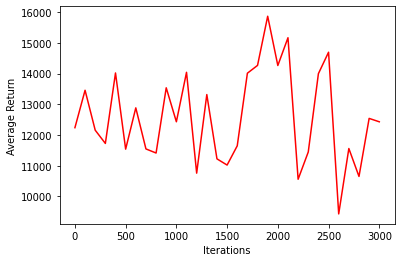

In [ ]:
#@test {"skip": true}

iterations = range(0, num_iterations + 1, eval_interval)
plt.plot(iterations, returns, color='red')
plt.ylabel('Average Return')
plt.xlabel('Iterations')
#plt.ylim(top=250)